In [88]:
import numpy as np
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1FGPFuPhDm7TP4ldlONogjAUtoskOay1J"})
downloaded.GetContentFile('train.csv') 
train = pd.read_csv('train.csv') 
downloaded = drive.CreateFile({'id':"1hB6XLrMXVgyFIjZ-tpS2x0u0aegIh5rY"})
downloaded.GetContentFile('val.csv') 
val = pd.read_csv('val.csv') 

In [89]:
x_train = train['review']
y_train = train['condition']
x_validation = val['review']
y_validation = val['condition']

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
# import scipy.sparse as sp
unigram_vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))
bigram_vec = TfidfVectorizer(analyzer='word', ngram_range=(2, 2))
trigram_vec = TfidfVectorizer(analyzer='word', ngram_range=(3, 3))
unibigram_vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 2))
bitrigram_vec = TfidfVectorizer(analyzer='word', ngram_range=(2, 3))
unibitrigram_vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 3))

unigram_train = unigram_vec.fit_transform(x_train)
bigram_train = bigram_vec.fit_transform(x_train)
trigram_train = trigram_vec.fit_transform(x_train)
unibigram_train = unibigram_vec.fit_transform(x_train)
bitrigram_train = bitrigram_vec.fit_transform(x_train)
unibitrigram_train = unibitrigram_vec.fit_transform(x_train)

n_features_1 = unigram_train.todense().shape[1]
n_features_2 = bigram_train.todense().shape[1]
n_features_3 = trigram_train.todense().shape[1]
n_features_12 = unibigram_train.todense().shape[1]
n_features_23 = bitrigram_train.todense().shape[1]
n_features_123 = unibitrigram_train.todense().shape[1]

In [91]:
x_train

0      dentist prescribe really rough wisdom tooth re...
1        issue every day almost issue notice side effect
2      medication mg x daily chest pain shortness bre...
3      start take medication migraine yesterday altho...
4      work admirably immediate control reflux sympto...
                             ...                        
689    medicine okay certainly get rid paranoid thoug...
690    make long story short miss year quality time c...
691    im diagnose bipolar disorder psychotic feature...
692    ive use week far skin seem peel burn however c...
693    get vilolently sick vomit migraine stomach cra...
Name: review, Length: 694, dtype: object

In [92]:
x_validation

0      struggle acne half life try counter remedy ben...
1      nutshell even though want drug work hate take ...
2      intense pain along bottom rib second round car...
3      sooo im unwillingly pretty prone yi didnt opti...
4      personally terrible experience dexilant acid r...
                             ...                        
293    start take loseasonique live busy lifestyle qu...
294    stuff really awful within week tear bicep hand...
295    va prescribe medication use year find excessiv...
296    side effect increase time arrythmia chest pain...
297    three year ago go doctor get severely ill ever...
Name: review, Length: 298, dtype: object

In [93]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from time import time
import matplotlib.pyplot as plt


def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time


In [94]:
tfidfvec = TfidfVectorizer()
svc = SVC()

In [95]:
# max_f_percentage = np.arange(0.1,1.1,0.1)
def n_features(n_features_x):
    return [int(np.floor(n_features_x*0.1)),int(np.floor(n_features_x*0.2)),int(np.floor(n_features_x*0.3)),int(np.floor(n_features_x*0.4)),int(np.floor(n_features_x*0.5)),int(np.floor(n_features_x*0.6)),int(np.floor(n_features_x*0.7)),int(np.floor(n_features_x*0.8)),int(np.floor(n_features_x*0.9)),n_features_x]

n_features_uni = n_features(n_features_1)
n_features_bi = n_features(n_features_2)
n_features_tri = n_features(n_features_3)
n_features_unibi = n_features(n_features_12)
n_features_bitri = n_features(n_features_23)
# n_features_unitri = n_features(n_features_13)
n_features_unibitri = n_features(n_features_123)

In [96]:
def nfeature_accuracy_checker(vectorizer=tfidfvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=svc):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [97]:
#unitrigram
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
def utg_accuracy():
    res = []
    check_vectorizer = CountVectorizer(ngram_range=(1,3)).fit(x_train)
    check2_vectorizer = CountVectorizer(ngram_range=(2,2)).fit(x_train)
    total_features = len(check_vectorizer.get_feature_names()) - len(check2_vectorizer.get_feature_names())
    max_f_13 = n_features(total_features) 
    for n in max_f_13:
        tfidf_vectorizer = CountVectorizer(ngram_range=(1,3),max_features=n)
        a = tfidf_vectorizer.fit_transform(x_train)
        b = a.todense().tolist()
        c = pd.DataFrame(b,columns=tfidf_vectorizer.get_feature_names())
        selected_train_column = [sel_c for sel_c in c.columns if len(sel_c.split())!=2]
        c = c[selected_train_column]

        a2 = tfidf_vectorizer.transform(x_validation)
        b2 = a2.todense().tolist()
        c2 = pd.DataFrame(b2, columns=tfidf_vectorizer.get_feature_names())

        selected_validation_column = [sel_c for sel_c in c2.columns if len(sel_c.split())!=2]
        c2 = c2[selected_validation_column]

        tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
        m_train = tfidf_transformer.fit_transform(c)
        v_train = m_train.todense().tolist()

        m_validation = tfidf_transformer.fit_transform(c2)
        v_validation = m_validation.todense().tolist()
        model = svc.fit(v_train,y_train)
        
        y_pred = model.predict(v_validation)
        print(accuracy_score(y_validation,y_pred))
        res.append((n*100,accuracy_score(y_validation,y_pred)))
    return res

In [98]:
feature_result_ug = nfeature_accuracy_checker(n_features=n_features_uni)
feature_result_ubg = nfeature_accuracy_checker(n_features=n_features_unibi,ngram_range=(1, 2))
feature_result_ubtg = nfeature_accuracy_checker(n_features=n_features_unibitri,ngram_range=(1, 3))
feature_result_btg = nfeature_accuracy_checker(n_features=n_features_bitri,ngram_range=(2, 3))
feature_result_bg = nfeature_accuracy_checker(n_features=n_features_bi,ngram_range=(2, 2))
feature_result_tg = nfeature_accuracy_checker(n_features=n_features_tri,ngram_range=(3, 3))
feature_result_utg = utg_accuracy()

nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ubg = pd.DataFrame(feature_result_ubg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ubtg = pd.DataFrame(feature_result_ubtg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_btg = pd.DataFrame(feature_result_btg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_utg = pd.DataFrame(feature_result_utg,columns=['nfeatures','validation_accuracy'])

# print(nfeatures_plot_ug.tail())
# print(nfeatures_plot_bg.tail())
# print(nfeatures_plot_ubg.tail())

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Validation result for 339 features
null accuracy: 51.01%
accuracy score: 87.58%
model is 36.58% more accurate than null accuracy
train and test time: 0.21s
--------------------------------------------------------------------------------
Validation result for 678 features
null accuracy: 51.01%
accuracy score: 89.60%
model is 38.59% more accurate than null accuracy
train and test time: 0.25s
--------------------------------------------------------------------------------
Validation result for 1017 features
null accuracy: 51.01%
accuracy score: 90.27%
model is 39.26% more accurate than null accuracy
train and test time: 0.26s
--------------------------------------------------------------------------------
Validation result for 1356 features


In [99]:
print("Total features in unigram: {}".format(n_features_1))
print("Total features in bigram: {}".format(n_features_2))
print("Total features in trigram: {}".format(n_features_3))
print("Total features in unibigram: {}".format(n_features_12))
print("Total features in unitrigram: {}".format(nfeatures_plot_utg['nfeatures'][9]))
print("Total features in bitrigram: {}".format(n_features_23))
print("Total features in unibitrigram: {}".format(n_features_123))

Total features in unigram: 3392
Total features in bigram: 19276
Total features in trigram: 23475
Total features in unibigram: 22668
Total features in unitrigram: 2686700
Total features in bitrigram: 42751
Total features in unibitrigram: 46143


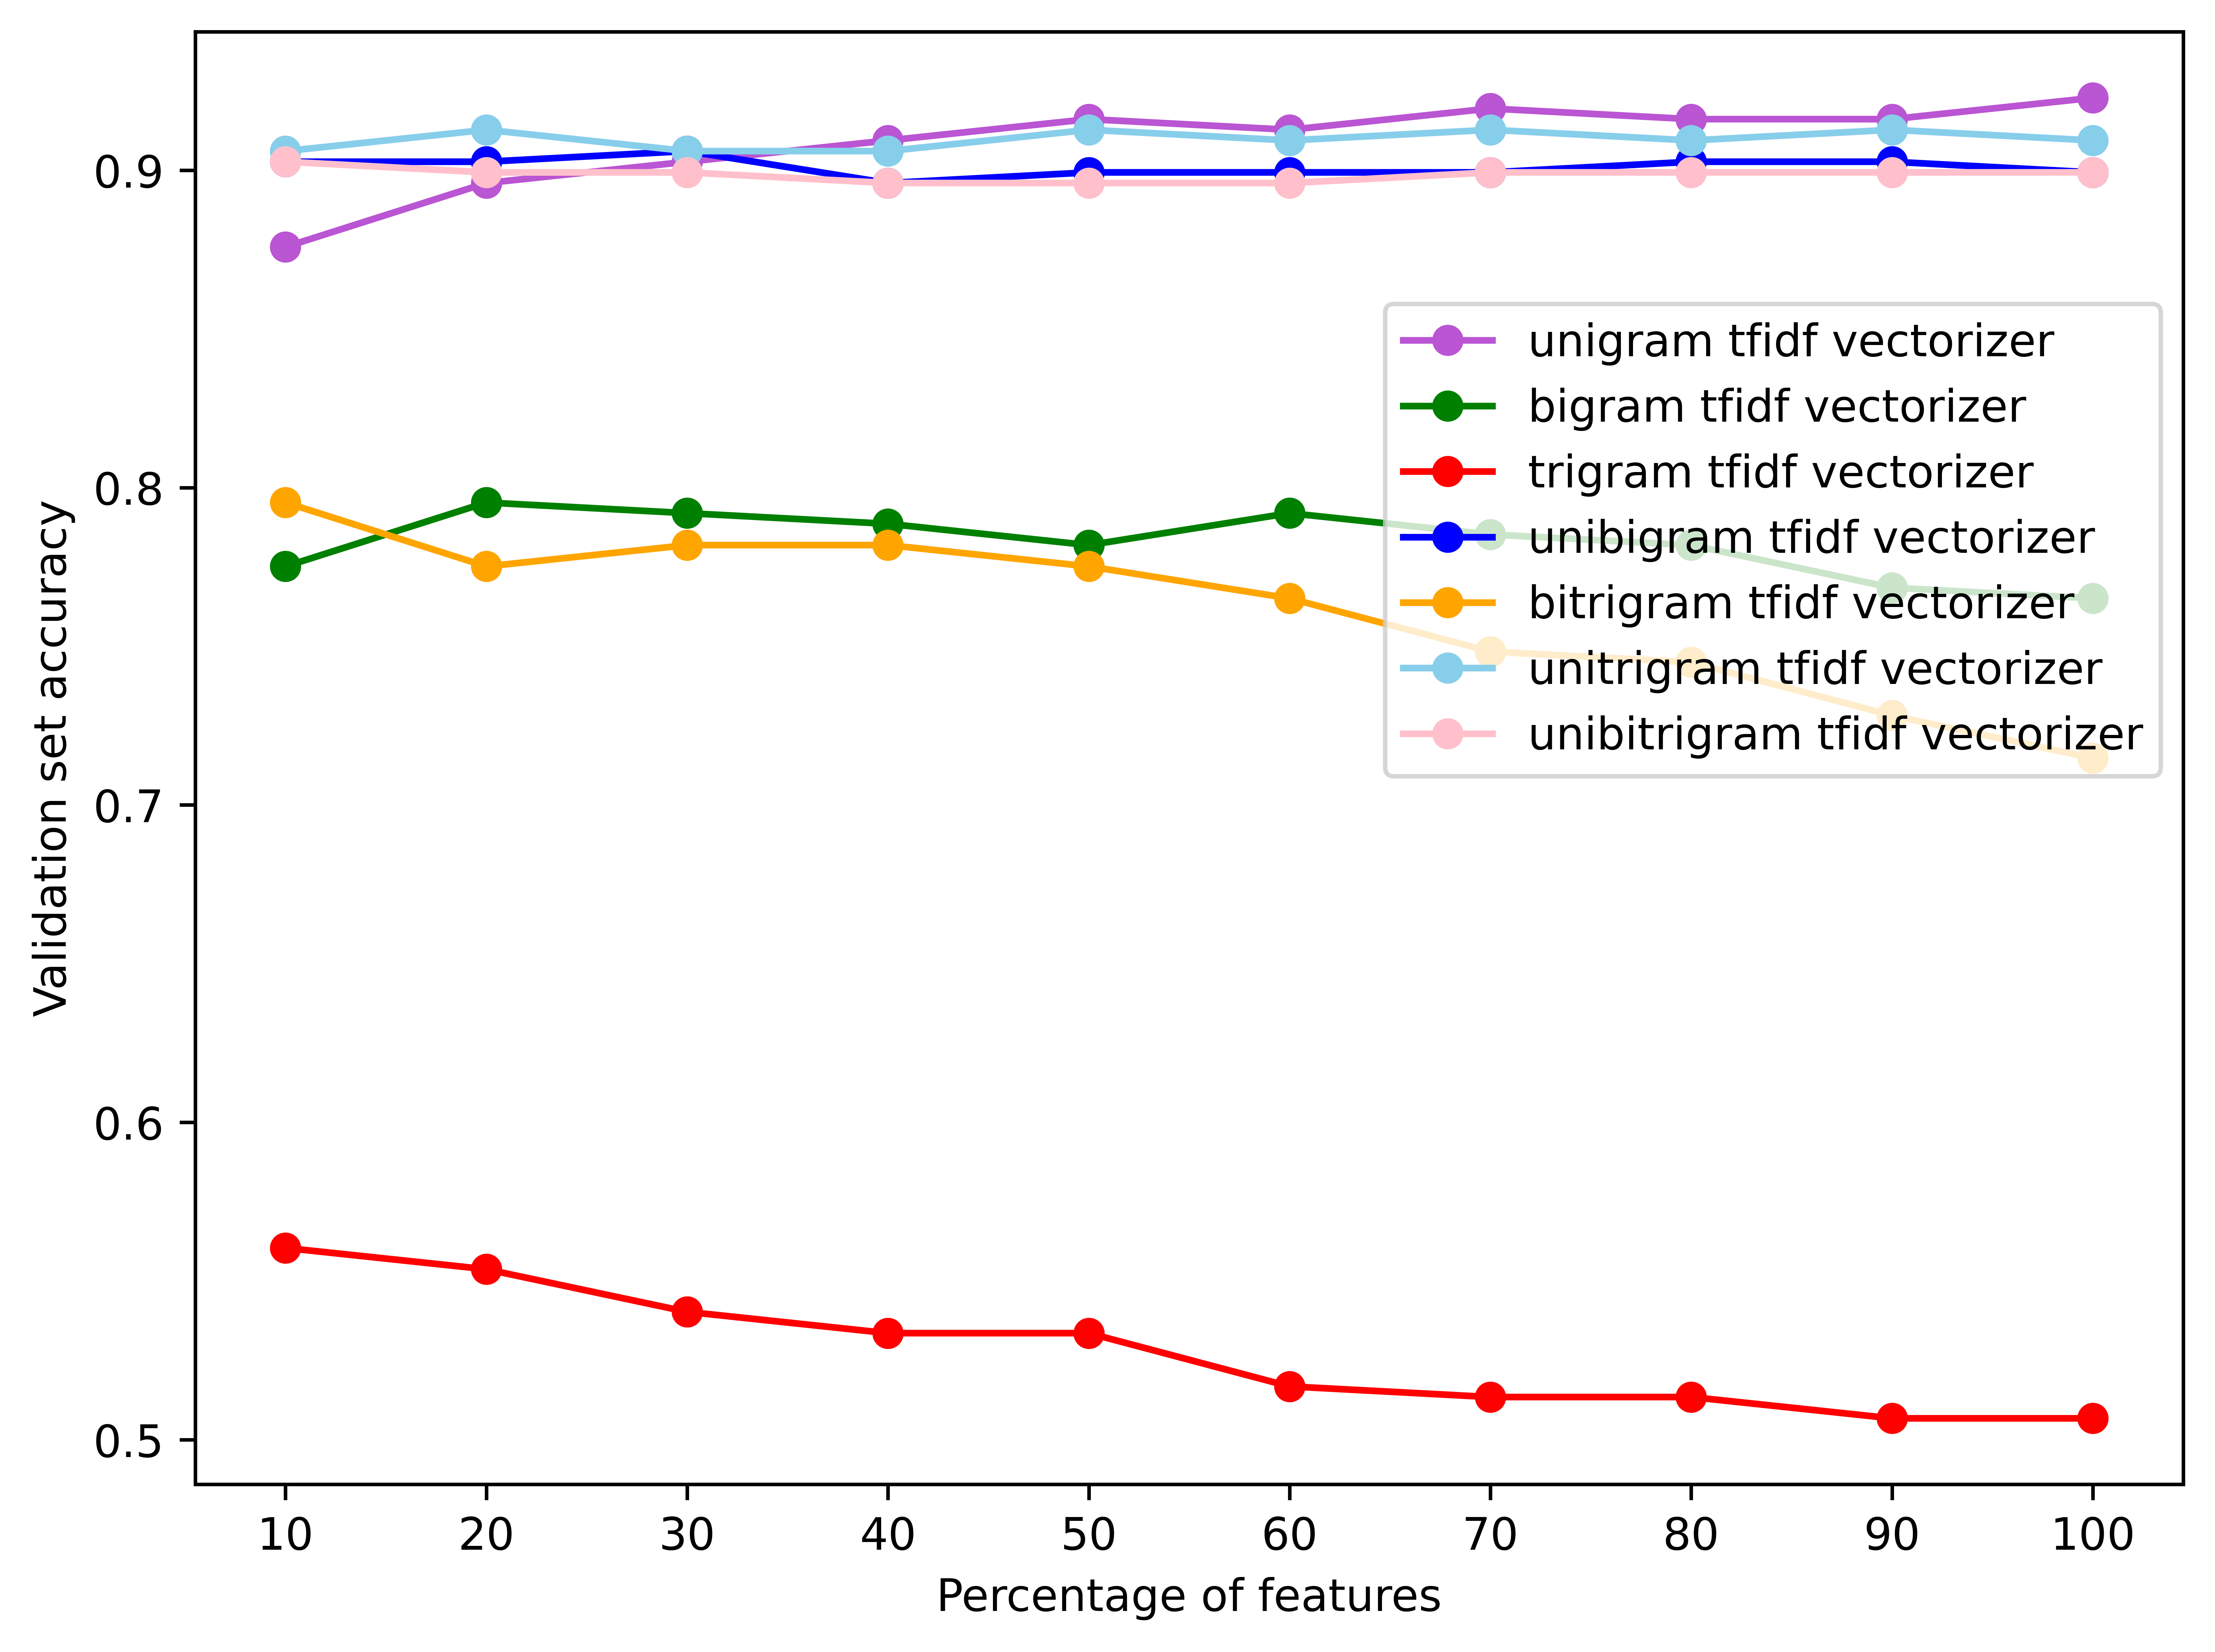

In [100]:
percentage = [10,20,30,40,50,60,70,80,90,100]
plt.figure(figsize=(8,6))
plt.plot(percentage, nfeatures_plot_ug.validation_accuracy, label='unigram tfidf vectorizer',color='mediumorchid',marker='o')
plt.plot(percentage, nfeatures_plot_bg.validation_accuracy,label='bigram tfidf vectorizer',color='green',marker='o')
plt.plot(percentage, nfeatures_plot_tg.validation_accuracy,label='trigram tfidf vectorizer',color='red',marker='o')
plt.plot(percentage, nfeatures_plot_ubg.validation_accuracy,label='unibigram tfidf vectorizer',color='blue',marker='o')
plt.plot(percentage, nfeatures_plot_btg.validation_accuracy,label='bitrigram tfidf vectorizer',color='orange',marker='o')
plt.plot(percentage, nfeatures_plot_utg.validation_accuracy,label='unitrigram tfidf vectorizer',color='skyblue',marker='o')
plt.plot(percentage, nfeatures_plot_ubtg.validation_accuracy, label='unibitrigram tfidf vectorizer',color='pink',marker='o')

plt.xticks(percentage)
plt.gcf().set_dpi(1000)
# plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Percentage of features")
plt.ylabel("Validation set accuracy")
plt.legend(loc=7, bbox_to_anchor=(1, 0.65))

In [101]:
# pd.DataFrame(feature_result_ug, label=['nfeature'])
# feature_result_ug# 
ng = []
ng.extend(['unigram'] * 10)
ng.extend(['bigram'] * 10)
ng.extend(['trigram'] * 10)
ng.extend(['unibigram'] * 10)
ng.extend(['unitrigram'] * 10)
ng.extend(['bitrigram'] * 10)
ng.extend(['unibitrigram'] * 10)

feature_percentage = []  
feature_percentage.extend(percentage*7)

accuracy = []
accuracy.append([f[1] for f in feature_result_ug])
accuracy.append([f[1] for f in feature_result_bg])
accuracy.append([f[1] for f in feature_result_tg])
accuracy.append([f[1] for f in feature_result_ubg])
accuracy.append([f[1] for f in feature_result_btg])
accuracy.append([f[1] for f in feature_result_utg])
accuracy.append([f[1] for f in feature_result_ubtg])
from functools import reduce
accuracy = reduce(lambda x,y: x+y, accuracy)
pd.DataFrame([''])
df_accuracy_ngram = pd.DataFrame({'n_gram': ng,
                    'Percentage of Features':feature_percentage,
                    'Accuracy': accuracy})

In [102]:
df_accuracy_ngram

,n_gram,Percentage of Features,Accuracy
0,unigram,10,0.875839
1,unigram,20,0.895973
2,unigram,30,0.902685
3,unigram,40,0.909396
4,unigram,50,0.916107
...,...,...,...
65,unibitrigram,60,0.895973
66,unibitrigram,70,0.899329
67,unibitrigram,80,0.899329
68,unibitrigram,90,0.899329


In [103]:
df_accuracy_ngram.sort_values(by='Accuracy', ascending=False)

,n_gram,Percentage of Features,Accuracy
9,unigram,100,0.922819
6,unigram,70,0.919463
8,unigram,90,0.916107
4,unigram,50,0.916107
7,unigram,80,0.916107
...,...,...,...
25,trigram,60,0.516779
27,trigram,80,0.513423
26,trigram,70,0.513423
28,trigram,90,0.506711


In [105]:
from google.colab import files
df_accuracy_ngram.to_excel("accuracy_comparison_ngram.xlsx",index = False)
files.download('accuracy_comparison_ngram.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>